In [13]:
import os
import numpy as np
import glob
import shutil
import xarray as xr
from astropy.time import Time
import museval
from museval.utils import get_response, find_response, aia_synthesis, wavelength_in_cube
from museval.io import create_session, is_complete
from muse.synthesis.synthesis import transform_resp_units, vdem_synthesis
from matplotlib import colors
import matplotlib.pyplot as plt
from muse.instr.utils import convert_resp2muse_ciresp
import astropy.units as u
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.wcs import WCS
from astropy.time import Time
import sunpy.map
import sunpy.visualization.colormaps as cm
from sunpy.time import parse_time
from dateutil.tz import gettz
import astropy.io.ascii as ascii
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import eispac
from museval.eis_calibration.eis_calib_2023 import calib_2023 as eis_calib_2023
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore", category=UserWarning, append=True)
warnings.filterwarnings(
    "ignore",
    message="Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata.*",
    category=RuntimeWarning
) #To ignore this  annoying Zarr warning

In [2]:
os.environ['RESPONSE'] = '/Users/souvikb/MUSE_outputs/response/'
os.environ['text_files_path'] = '/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/'
os.environ['eis_data_path'] = '/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/'
os.environ['vdem_path'] = '/Users/souvikb/MUSE_outputs/vdems/'
work_dir = '/Users/souvikb/MUSE_outputs/pipeline_figs_sims/'
##---- interactively select a VDEM based on your choice. A new dialogue box opens. -----##
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()  # Hide the root window
vdem_file = filedialog.askdirectory(
    title="Select a VDEM .zarr file",
    initialdir=os.environ['vdem_path']
)
print("Selected folder:", vdem_file)

2025-09-08 00:59:20.982 python[89536:34318523] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Selected folder: /Users/souvikb/MUSE_outputs/vdems/vdem_072.zarr


In [3]:
txt_files = glob.glob(os.path.join(os.environ['text_files_path'], "*.txt"))
txt_files = sorted(txt_files)
# txt_files
MHD_code, snapname = [s.strip() for s in input("Enter the MHD code and snapname, separated by a comma: ").split(",")]

In [ ]:
obs_dates = ascii.read(txt_files[0])
obs_dates.add_index("date_begin_EIS")

for date in tqdm(obs_dates['date_begin_EIS']):
    # print(date)
    date_sensitive = True
    unit = 'DN'
    date = Time(date,format='isot',scale='utc') # astropy time object
    print(f'Date Sensitive AIA {unit} Response from {date.strftime("%b %y")}')
    aia_resp = get_response(date = date, channels=[131,171,193,211],save_response=True, units=unit)
    muse_AIA = aia_synthesis(aia_resp, work_dir, vdem_file, swap_dims = False)
    print('Creating historgrams from the synthesized AIA data')
    fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(4,8),sharex=True)
    ax.ravel()
    colors_channel = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    channels = [131,171,193,211]
    num_bins=40
    for i, channel in enumerate([131,171,193,211]):
        synth_aiadata = muse_AIA.flux.sel(channel=channel).to_numpy()
        # bins = np.linspace(muse_AIA.flux.sel(channel=channel).min(), muse_AIA.flux.sel(channel=channel).max(), num_bins)
        min_val = max(muse_AIA.flux.sel(channel=channel).min(), 1e-1)  # avoid log(0)
        max_val = muse_AIA.flux.sel(channel=channel).max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
        hist, bin_edges = np.histogram(synth_aiadata, bins=bins)
        
        ax[0].hist(synth_aiadata.ravel(), bins=bins, histtype='step',color=colors_channel[i], 
                   label=f'AIA {channel}',weights=np.ones(len(synth_aiadata.ravel())) / len(synth_aiadata.ravel()))
        
        ax[0].legend(loc = 'best')
        ax[0].set_xscale('log')
        ax[0].set_ylabel('Fraction')

        ax[1].hist(synth_aiadata.ravel(), bins=bins, histtype='step', color=colors_channel[i],cumulative=True,
                weights=np.ones(len(synth_aiadata.ravel())) / len(synth_aiadata.ravel()))
        ax[1].set_xlabel(r'Intensity [DNs$^{-1}$]')
        ax[1].set_xscale('log')
        ax[1].set_ylabel('ECDF')
        ax[1].axvline(x=np.mean(synth_aiadata.ravel()),color=colors_channel[i],lw=0.5,ls='--',
                      label=f'$\mu_{{{channel}}}$ {np.mean(synth_aiadata.ravel()):.2f}')
        ax[1].set_xlim([1,muse_AIA.flux.max().to_numpy()*1.1])
        ax[1].legend(loc='best', fontsize='small')
    fig.suptitle(f'{MHD_code} simulation: {snapname}',y=0.98,horizontalalignment='center')
    plt.tight_layout()
    # plt.show()
    os.makedirs(f'{work_dir}/{MHD_code}_{snapname}_synth_histograms/', exist_ok=True)
    fig.savefig(f'{work_dir}/{MHD_code}_{snapname}_synth_histograms/histograms.png', dpi=300,bbox_inches='tight')
    plt.close(fig)

    date_begin_EIS = obs_dates.loc[date]["date_begin_EIS"]
    cutouts_data_path = os.path.join(os.environ['eis_data_path'], "SDO_EIS_cutouts_"+date_begin_EIS)
    cutout_files = sorted(glob.glob(os.path.join(cutouts_data_path, 'cutout_*.fits')))
    print('The cutout files are:\n' + '\n'.join(cutout_files))
    if not cutout_files:
        print(f"No cutout files found in {cutouts_data_path}")
        continue
    AIA_DATA = {} # Initialize the dictionary
    # Dynamically calculate figure size based on the number of subplots and aspect ratio
    for idx_line, line in enumerate(channels):
        AIA_DATA[line] = sunpy.map.Map(cutout_files[idx_line])
    # Number of panels
    n_lines = len(channels)
    # Get one map to measure aspect ratio
    sample_map = AIA_DATA[channels[0]]
    ny, nx = sample_map.data.shape
    aspect = ny / nx  # height / width

    # Set figure size dynamically
    panel_width = 4  # good width per panel (in inches)
    fig_width = panel_width * n_lines
    fig_height = panel_width * aspect
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    for idx_line, line in enumerate(channels):
        AIA_DATA[line] = sunpy.map.Map(cutout_files[idx_line])
        exp_time = AIA_DATA[line].exposure_time
        data = AIA_DATA[line]/exp_time
        ax = fig.add_subplot(1, n_lines, idx_line + 1, projection=AIA_DATA[line].wcs)
        ##Plotting the AIA cutouts
        im = data.plot(axes=ax, vmin=0)
        # ax.set_title(data.wavelength.to_string('latex'), fontsize=10)
        ax.grid(False)
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_ticks_position('b')      # ticks on bottom
        lon.set_ticklabel_position('b')  # bottom

        lat.set_ticks_position('l')      # ticks on left
        lat.set_ticklabel_position('l')  # left
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
        cbar = fig.colorbar(im, cax=cax)
        cbar.ax.tick_params(direction='out')
        cbar.ax.yaxis.set_ticks_position('right')
        cbar.ax.yaxis.set_label_position('right')
        cbar.ax.yaxis.tick_right()
        cbar.set_label(r'DNs$^{-1}$')
    plt.tight_layout()
    # plt.show()
    os.chdir(cutouts_data_path)
    output_dir = './pipeline_figs'
    os.makedirs(output_dir, exist_ok=True) 
    fig.savefig(os.path.join(output_dir,f"{date}_cutouts.png"),dpi=300,bbox_inches='tight')
    plt.close(fig)

    ## ------ Comparison between given AIA lines and synthesized AIA data ------ ##
    region = 'plage'
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    for i,channel in enumerate(channels):
        exp_time = AIA_DATA[channel].exposure_time
        data = np.ravel(AIA_DATA[channel].data/exp_time)
        bf = muse_AIA.flux.sel(channel=channel).to_numpy()
        combined = np.concatenate([data.value, bf.ravel()])
        min_val = max(combined.min(), 1e-1)  # avoiding log(0). This can be nasty otherwise
        max_val = combined.max()
        bins_new = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
        # bins_new = np.linspace(combined.min(), combined.max(), 60)
        hist, bin_edges = np.histogram(data.value, bins=bins_new)
        ax[i//2][i%2].hist(data.value, bins=bins_new, label=f'AIA {region}',cumulative=True, histtype='step',
                           weights=np.ones(len(data.value)) / len(data.value), color=colors_channel[i])
        ax[i//2][i%2].axvline(x=np.mean(data.value),color=colors_channel[i],lw=1,ls='-',
                              label=f'$\mu_{{\mathrm{{obs}}}}$: {np.mean(data.value):.2f} [DNs$^{-1}$]')

        ax[i//2][i%2].hist(bf.ravel(), bins=bins_new, label=f'{MHD_code} {snapname}',cumulative=True, histtype='step',
                           weights=np.ones(len(bf.ravel())) / len(bf.ravel()),color='tab:purple',ls='-.',lw=2.)
        ax[i//2][i%2].axvline(x=np.mean(bf.ravel()),color='tab:purple',lw=1,ls='-.',label=f'$\mu_{{\mathrm{{syn}}}}$: {np.mean(bf.ravel()):.2f} [DNs$^{-1}$]')
        ax[i//2][i%2].set_xlabel(fr'{channel} Intensity [DNs$^{-1}$]')
        ax[i//2][i%2].set_xlim([1, max_val * 1.1])
        # if channel == 171:
        #     ax[i//2][i%2].set_xlim([1, 1e4])
        # elif channel == 193:
        #     ax[i//2][i%2].set_xlim([1, 1e4])
        # elif channel == 211:
        #     ax[i//2][i%2].set_xlim([1, 3e3])
        # elif channel == 131:
        #     ax[i//2][i%2].set_xlim([1, 1e3])
        ax[i//2][i%2].set_xscale('log')
        ax[i//2][i%2].set_ylabel('ECDF')
        ax[i//2][i%2].legend(loc='lower right')
        ax[i//2][i%2].axhline(y=0.25,color='black',ls='--')
        ax[i//2][i%2].axhline(y=0.75,color='black',ls='--')

    date = AIA_DATA[channel].date.strftime('%Y-%m-%d')
    title = f"AIA {region} {date} vs {MHD_code} {snapname}"
    fig.suptitle(title,y=0.98)
    fig.suptitle(title,y=0.98)
    plt.tight_layout()
    # plt.show()

    os.chdir(cutouts_data_path)
    output_dir = './pipeline_figs'
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir,f"{date}_{MHD_code}_{snapname}_comparison_hist.png"),dpi=300,bbox_inches='tight')
    plt.close(fig)
    
    # print('\n Now begin the EIS data analysis for the same date and region...')
    # downloaded_data_h5 = glob.glob(cutouts_data_path+'/*.data.h5')
    # downloaded_head_h5 = glob.glob(cutouts_data_path+'/*.head.h5')
    # data = eispac.read_cube(downloaded_data_h5[0])
    # headers = eispac.read_cube(downloaded_head_h5[0])

AttributeError: 'builtin_function_or_method' object has no attribute 'read'

### Test EIS data by including Fe IX 

In [ ]:
obs_dates = ascii.read(txt_files[0])
obs_dates.add_index("date_begin_EIS")
for date in tqdm(obs_dates['date_begin_EIS']):
    date_begin_EIS = obs_dates.loc[date]["date_begin_EIS"]
    print(f'Processing EIS data for date: {date_begin_EIS}')
    cutouts_data_path = os.path.join(os.environ['eis_data_path'], "SDO_EIS_cutouts_"+date_begin_EIS)
    downloaded_data_h5 = glob.glob(cutouts_data_path+'/*.data.h5')
    downloaded_head_h5 = glob.glob(cutouts_data_path+'/*.head.h5')
    #check if the variables are empty or not before proceeding with the next steps
    if not downloaded_data_h5 or not downloaded_head_h5:
        print(f"No data or header files found in {cutouts_data_path}")
        continue
    else:
        data = eispac.read_cube(downloaded_data_h5[0])
        headers = eispac.read_cube(downloaded_head_h5[0])
        eis_lines = [195.120,197.860, 284.160] # Fe XII, Fe IX and Fe XV
        target_template_name = ['fe_12_195_119.2c.template.h5', 'fe_09_197_862.1c.template.h5','fe_15_284_160.2c.template.h5']
        eis_cmap = ['sdoaia193','Blues_r','sohoeit284']
        eis_list_data = [] # To check how many if not all lines listed above are available in the actual EIS data
        data_intensity_maps = [] # To store the intensity maps for all the available lines in the actual EIS data.
        for target_template, eis_spect in zip(target_template_name,eis_lines):
            eis_list_data.append(wavelength_in_cube(downloaded_data_h5[0],str(eis_spect)))
            if wavelength_in_cube(downloaded_data_h5[0], str(eis_spect)):
                data_cube = eispac.read_cube(downloaded_data_h5[0], eis_spect, apply_radcal=True)
                template_list = eispac.match_templates(data_cube)
                index = next(i for i, path in enumerate(template_list) if path.name == target_template)
                shutil.copy(template_list[index], cutouts_data_path)
                if __name__ == '__main__':
                    template = glob.glob(os.path.join(cutouts_data_path,target_template))#'fe_12*.template.h5'))
                    template_filepath = template[0]
                    tmplt = eispac.read_template(template_filepath)
                    # Read spectral window into an EISCube
                    data_cube = eispac.read_cube(downloaded_data_h5[0], tmplt.central_wave,apply_radcal=True)
                    fit_res = eispac.fit_spectra(data_cube, tmplt, ncpu='max')
                    inten_map = fit_res.get_map(component=0, measurement='intensity')
                    inten_map = eis_calib_2023(inten_map)
                    data_intensity_maps.append(inten_map.data) # Collecting the intensity arrays for plotting the histograms later
                    vel_map = fit_res.get_map(component=0, measurement='velocity')
                    # wd_map = fit_res.get_map(component=0, measurement='width')
                        # Get one map to measure aspect ratio
                    sample_map = inten_map  # or any map with the correct shape
                    ny, nx = sample_map.data.shape
                    aspect = ny / nx  # height / width
                    panel_width = 4  # inches per panel (adjust as needed)
                    panel_height = panel_width * aspect
                    fig_width = panel_width * 2.4  # extra space for colorbars
                    # fig_width = panel_width * 2  # two panels side by side
                    fig_height = panel_height  # two panels stacked vertically
                    # fig_height = panel_width * aspect/8.  # maintain aspect
                    fig = plt.figure(figsize=(fig_width, fig_height)) 
                    gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 1], wspace=0.25)
                    ax1 = fig.add_subplot(gs[0], projection=inten_map)
                    if target_template == 'fe_12_195_119.2c.template.h5':
                        # ax1 = fig.add_subplot(121,projection=inten_map)
                        im=inten_map.plot(axes=ax1, cmap = eis_cmap[0])
                        cbar =fig.colorbar(im,extend='both',fraction=0.05,pad=0.05)
                        cbar.ax.set_ylabel(r'[erg s$^{-1}$ cm$^{-2}$ s$^{-1}$]')
                        ax1.set_title(f'Fe XII {eis_spect}',size=10)
                        ax1.grid(False)
                    elif target_template == 'fe_09_197_862.1c.template.h5':
                        # ax1 = fig.add_subplot(121,projection=inten_map)
                        im=inten_map.plot(axes=ax1, cmap = eis_cmap[1])
                        cbar=fig.colorbar(im,extend='both',fraction=0.05,pad=0.05)
                        cbar.ax.set_ylabel(r'[erg s$^{-1}$ cm$^{-2}$ s$^{-1}$]')
                        ax1.set_title(f'Fe IX {eis_spect}',size=10)
                        ax1.grid(False)
                    else:
                        # ax1 = fig.add_subplot(121,projection=inten_map)
                        im=inten_map.plot(axes=ax1, cmap = eis_cmap[2])
                        cbar=fig.colorbar(im,fraction=0.05,pad=0.05)
                        cbar.ax.set_ylabel(r'[erg s$^{-1}$ cm$^{-2}$ s$^{-1}$]')
                        ax1.set_title(f'Fe XV {eis_spect}',size=10)
                        ax1.grid(False)
                    
                    vel_map.plot_settings["norm"]=None
                    ax2 = fig.add_subplot(gs[1],projection=vel_map)
                    im=vel_map.plot(axes=ax2,vmax=10,vmin=-10,cmap='coolwarm')
                    cbar=fig.colorbar(im,extend ='both', fraction=0.046,pad=0.05)
                    cbar.ax.set_ylabel(r'[kms$^{-1}$]')
                    ax2.set_title(r'Core shift',size=10)
                    ax2.grid(False)
                    plt.tight_layout()
                    # plt.show()
                    os.chdir(cutouts_data_path)
                    output_dir = './pipeline_figs'
                    os.makedirs(output_dir, exist_ok=True)
                    print('Saving the EIS maps')
                    fig.savefig(os.path.join(output_dir,f"{date}_EIS_{eis_spect}.png"),dpi=300,bbox_inches='tight')
                    plt.close(fig)
            else:
                print(f"Skipping wavelength {eis_spect} Å: Not found in {downloaded_data_h5[0]}")
    # Plotting the EIS intensity histograms
    n_panels_eis_hist = sum(eis_list_data)
    fig, ax = plt.subplots(nrows=1, ncols=n_panels_eis_hist, figsize=(12, 4.))
    ax = np.atleast_1d(ax)
    eis_hist_bins = 60 # hard coded for now
    for i, (eis_spect, intensity_map) in enumerate(zip(eis_lines, data_intensity_maps)):
        if eis_list_data[i]:
            # Get the intensity data for the current line
            intensity_data = intensity_map.ravel()
            min_int = max(intensity_data.min(), 1e-1)  # avoid log(0)
            max_int = intensity_data.max()
            # Create histogram bins
            bins = np.logspace(np.log10(min_int), np.log10(max_int), eis_hist_bins)
            # Plot histogram
            ax[i].hist(intensity_data, bins=bins, histtype='step', cumulative=False,
                        weights=np.ones(len(intensity_data)) / len(intensity_data), color='blue')
            ax[i].set_xlabel(r'Intensity [ergs cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
            ax[i].set_ylabel('Fraction')
            ax[i].axvline(x=np.mean(intensity_data), color='red', lw=1, ls='-',label='Mean')
            ax[i].legend(loc='upper left')
            ax[i].set_title(f'EIS {eis_spect} {date_begin_EIS}',size=10)

            color='tab:green'
            axs_twin=ax[i].twinx()
            axs_twin.hist(intensity_data, bins=bins, histtype='step', cumulative=True,
                        weights=np.ones(len(intensity_data)) / len(intensity_data), color='green', ls='-')
            axs_twin.axhline(y=0.25, linestyle='dashed',color='green')
            axs_twin.axhline(y=0.75, linestyle='dashed',color='green')
            axs_twin.set_ylabel('ECDF',color='green')
            axs_twin.tick_params(axis='y', labelcolor=color)
        else:
            print(f"Skipping wavelength {eis_spect} Å: Not found in {downloaded_data_h5[0]}")
    
    # Adjust layout and show the plot
    plt.tight_layout()
    os.chdir(cutouts_data_path)
    output_dir = './pipeline_figs'
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir,f"{date}_EIS_intensity_histograms.png"), dpi=300, bbox_inches='tight')
    plt.close(fig)

    print('Now plotting the HMI LOS flux density cutouts for the same date and region...')
    ## Plotting the HMI LOS flux density cutouts
    # First grab the cutout region from the full disk HMI data
    bottom_left = SkyCoord(data.meta['extent_arcsec'][0]*u.arcsec, data.meta['extent_arcsec'][2]*u.arcsec, obstime=data.meta['mod_index']['date_obs'], observer="earth", frame="helioprojective")
    top_right = SkyCoord(data.meta['extent_arcsec'][1]*u.arcsec, data.meta['extent_arcsec'][3]*u.arcsec, obstime=data.meta['mod_index']['date_obs'], observer="earth", frame="helioprojective")

    ## Load the HMI data as sunpy map
    hmi_map = sunpy.map.Map(cutouts_data_path+'/*magnetogram.fits') ## This will  be rotated by 90 degrees as usual
    ## Load an AIA map to get the WCS
    aia_map_fdisk = sunpy.map.Map(cutouts_data_path+'/*.193.image_lev1.fits')
    out_hmi = hmi_map.reproject_to(aia_map_fdisk.wcs) ## actual reprojection from HMI to AIA based on WCS headers
    cutout_hmi_aligned = out_hmi.submap(bottom_left,top_right=top_right) ## this is the cutout 
    ## Now dynamically calculate figure size based on the number of subplots and aspect ratio
    ny, nx = cutout_hmi_aligned.data.shape
    aspect = ny / nx
    panel_width = 4
    fig_width = panel_width * 2
    fig_height = aspect*fig_width*0.9
    cutout_hmi_aligned.plot_settings["norm"]=None

    fig= plt.figure(figsize=(fig_width,fig_height))
    ax = fig.add_subplot(2, 2, 1, projection=cutout_hmi_aligned.wcs)
    im = cutout_hmi_aligned.plot(axes=ax, vmax=0.3*np.max(cutout_hmi_aligned.data), vmin=-0.3*np.max(cutout_hmi_aligned.data))
    ax.grid(False)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_position('b')      # ticks on bottom
    lon.set_ticklabel_position('b')  # bottom
    lat.set_ticks_position('l')      # ticks on left
    lat.set_ticklabel_position('l')  # left
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
    cbar = fig.colorbar(im, cax=cax,extend='both')
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')
    cbar.ax.yaxis.tick_right()
    cbar.set_label(r'B$_{\mathrm{LOS}}$[G]')

    ax = fig.add_subplot(2, 2, 2, projection=cutout_hmi_aligned.wcs)
    abs_data = np.abs(cutout_hmi_aligned.data) 
    abs_map = sunpy.map.Map(abs_data, cutout_hmi_aligned.meta)
    im = abs_map.plot(axes=ax, clip_interval=(1, 99.99)*u.percent,cmap='YlGnBu')
    ax.grid(False)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_position('b')      # ticks on bottom
    lon.set_ticklabel_position('b')  # bottom
    lat.set_ticks_position('l')      # ticks on left
    lat.set_ticklabel_position(' ')  # left
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
    cbar = fig.colorbar(im, cax=cax, extend ='both')
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')
    cbar.ax.yaxis.tick_right()
    cbar.set_label(r'|B$_{\mathrm{LOS}}$| [G]')
    #---- Histograms ------#
    bins = np.linspace(cutout_hmi_aligned.data.min(),cutout_hmi_aligned.data.max(),100)
    data_hmi = cutout_hmi_aligned.data
    ax = fig.add_subplot(2, 2, 3)
    ax.hist(data_hmi.ravel(),bins=bins, histtype='step',weights=np.ones(len(data_hmi.ravel()))/len(data_hmi.ravel()),log=True,color='blue')
    ax.set_ylabel('Fraction')
    ax.set_xlabel(r'B$_{\mathrm{LOS}}$[G]')
    ax.axvline(x=0,ls='-',color='black')
    
    bins = np.linspace(abs_data.min(),abs_data.max(),100)
    # data_hmi = cutout_hmi_aligned.data
    ax = fig.add_subplot(2, 2, 4)
    ax.hist(abs_data.ravel(),bins=bins, histtype='step',weights=np.ones(len(abs_data.ravel()))/len(abs_data.ravel()),log=True,color='blue')
    # ax.set_ylabel('Fraction')
    ax.set_xlabel(r'|B$_{\mathrm{LOS}}$| [G]')
    plt.subplots_adjust(left=0.1,right=0.9,top=0.9,bottom=0.1,wspace=0.3,hspace=0.2)
    ax.axvline(x=np.mean(abs_data),ls='--',color='black',label=f'$\mu$: {np.mean(abs_data):.2f} [G]')
    ax.legend(loc='best')
    # plt.show()
    # save_hmi = input("Do you want to save the HMI maps? (True/False): ")
    # Ensure the directory exists
    os.chdir(cutouts_data_path)
    output_dir = './pipeline_figs'
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir,f"{date}_HMI.png"),dpi=300,bbox_inches='tight') 
    plt.close(fig)

    ## Plot a fukll disk AIA map and draw the cutout region
    exp_time_fdisk = aia_map_fdisk.exposure_time
    data_fdisk = aia_map_fdisk/exp_time_fdisk
    fig = plt.figure()
    ax = fig.add_subplot(projection=data_fdisk)
    im = data_fdisk.plot(axes=ax, vmin=0)
    ax.grid(False)
    divider= make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(direction='out')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')
    cbar.ax.yaxis.tick_right()
    cbar.set_label('DN/s')
    cutout_hmi_aligned.draw_extent(axes=ax)
    # plt.show()
    os.chdir(cutouts_data_path)
    output_dir = './pipeline_figs'
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir,f"{date}_AIA_fdisk.png"),dpi=300,bbox_inches='tight')
    plt.close(fig)



  0%|          | 0/12 [00:00<?, ?it/s]

Processing EIS data for date: 2017-06-07T04:41:20
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/eis_20170607_044213.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/eis_20170607_044213.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/eis_20170607_044213.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/eis_20170607_044213.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/eis_20170607_044213.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-07T04:41:20/eis_20170607_044213.head.h5
Found a wavelength 195.12 [Angstroms] in win

  8%|▊         | 1/12 [00:48<08:48, 48.03s/it]

Processing EIS data for date: 2017-06-08T01:02:39
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.head.h5
Found a wavelength 195.12 [Angstroms] in win

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:07.918037
   38400 spectra fit without issues
   384 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Skipping wavelength 197.86 Å: Not found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.data.h5
Skipping wavelength 284.16 Å: Not found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-08T01:02:39/eis_20170608_020012.data.h5
Now plotting the

 17%|█▋        | 2/12 [01:06<05:05, 30.59s/it]

Processing EIS data for date: 2017-06-09T11:59:28
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.head.h5
Found a wavelength 195.12 [Angstroms] in win

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:04.182322
   9280 spectra fit without issues
   320 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.head.h5
Found a wavelength 197.86 [Angstroms] in window 1
Data file,
   /Users/so

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:03.546015
   9280 spectra fit without issues
   320 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-09T11:59:28/eis_20170609_122842.head.h5
Found a wavelength 284.16 [Angstroms] in window 3
Data file,
   /Users/so

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:05.734298
   9440 spectra fit without issues
   160 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Now plotting the HMI LOS flux density cutouts for the same date and region...


 25%|██▌       | 3/12 [01:32<04:16, 28.50s/it]

Processing EIS data for date: 2017-06-17T13:48:01
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.head.h5
Found a wavelength 195.12 [Angstroms] in win

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:08.795335
   38400 spectra fit without issues
   384 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Skipping wavelength 197.86 Å: Not found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.data.h5
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/E

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:17.044974
   38400 spectra fit without issues
   384 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Skipping wavelength 197.86 Å: Not found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-17T13:48:01/eis_20170617_134814.data.h5
Now plotting the HMI LOS flux density cutouts for the same date and region...


 33%|███▎      | 4/12 [02:09<04:14, 31.81s/it]

Processing EIS data for date: 2017-06-18T02:17:09
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.head.h5
Found a wavelength 195.12 [Angstroms] in win

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:08.047339
   44032 spectra fit without issues
   512 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.head.h5
Found a wavelength 197.86 [Angstroms] in window 9
Data file,
   /Users/s

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:09.635641
   44032 spectra fit without issues
   512 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T02:17:09/eis_20170618_025913.head.h5
Found a wavelength 284.16 [Angstroms] in window 24
Data file,
   /Users/

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:164: RuntimeWarning: divide by zero encountered in scalar divide
  fit_dict['chi2'][ii,jj] = out.fnorm/out.dof


/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:17.823353
   43243 spectra fit without issues
   1301 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Now plotting the HMI LOS flux density cutouts for the same date and region...


 42%|████▏     | 5/12 [02:57<04:22, 37.56s/it]

Processing EIS data for date: 2017-06-18T12:56:45
No data or header files found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-18T12:56:45
Processing EIS data for date: 2017-06-20T05:36:52
No data or header files found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-20T05:36:52
Processing EIS data for date: 2017-06-21T04:48:09
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_20170621_045753.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_20170621_045753.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_20170621_045753.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_201

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:10.122831
   38400 spectra fit without issues
   384 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Skipping wavelength 197.86 Å: Not found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_20170621_045753.data.h5
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_20170621_045753.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/E

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:17.176726
   38400 spectra fit without issues
   384 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Skipping wavelength 197.86 Å: Not found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-06-21T04:48:09/eis_20170621_045753.data.h5
Now plotting the HMI LOS flux density cutouts for the same date and region...


 67%|██████▋   | 8/12 [03:35<01:30, 22.57s/it]

Processing EIS data for date: 2017-11-07T04:50:19
No data or header files found in /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T04:50:19
Processing EIS data for date: 2017-11-07T22:42:00
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.data.h5
Heade

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:04.167582
   9599 spectra fit without issues
   1 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-07T22:42:00/eis_20171107_230513.head.h5
Found a wavelength 284.16 [Angstroms] in window 3
Data file,
   /Users/souv

 83%|████████▎ | 10/12 [04:03<00:38, 19.36s/it]

Processing EIS data for date: 2017-11-08T08:26:53
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.head.h5
Found a wavelength 195.12 [Angstroms] in win

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:10.095131
   44030 spectra fit without issues
   514 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T08:26:53/eis_20171108_083219.head.h5
Found a wavelength 284.16 [Angstroms] in window 24
Data file,
   /Users/

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:20.420282
   43520 spectra fit without issues
   1024 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Now plotting the HMI LOS flux density cutouts for the same date and region...


 92%|█████████▏| 11/12 [04:55<00:26, 26.20s/it]

Processing EIS data for date: 2017-11-08T23:04:13
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.head.h5
Found a wavelength 195.12 [Angstroms] in win

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:10.021215
   44539 spectra fit without issues
   5 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2017-11-08T23:04:13/eis_20171108_233939.head.h5
Found a wavelength 284.16 [Angstroms] in window 24
Data file,
   /Users/so

/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:00:20.432789
   44032 spectra fit without issues
   512 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Saving the EIS maps
Now plotting the HMI LOS flux density cutouts for the same date and region...


100%|██████████| 12/12 [05:48<00:00, 29.05s/it]


In [9]:
eis_list_data

[]

In [15]:
downloaded_data_h5 = glob.glob('/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-24T20:34:56'+
                               '/*.data.h5')
downloaded_head_h5 = glob.glob('/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-24T20:34:56'+
                               '/*.head.h5')
data = eispac.read_cube(downloaded_data_h5[0])
headers = eispac.read_cube(downloaded_head_h5[0])

Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-24T20:34:56/eis_20180824_212107.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-24T20:34:56/eis_20180824_212107.head.h5
Found window 0
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-24T20:34:56/eis_20180824_205842.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-24T20:34:56/eis_20180824_205842.head.h5
Found window 0


In [16]:
downloaded_head_h5[0]
import h5py
file = h5py.File(downloaded_head_h5[0], 'r')
file.keys()
file['exposure_times']['duration'][:].max()


5.000797

In [17]:
wininfo = eispac.read_wininfo(downloaded_head_h5[0])
print(f"Window info: {wininfo}")

Window info: [(0, 'Ca XV 181.950', 181.59529, 182.28656, 32,  731)
 (1, 'Fe XXIV 191.950', 191.58293, 192.27385, 32, 1179)
 (2, 'Ca XV 200.980', 200.62984, 201.32043, 32, 1585)
 (3, 'Fe XXIII 263.300', 262.66843, 263.89255, 56, 2951)
 (4, 'Fe XIV 264.720', 264.44894, 264.96082, 24, 3031)
 (5, 'Fe XVII 269.400', 269.033  , 269.72275, 32, 3237)
 (6, 'Fe XIV 274.150', 273.88284, 274.39447, 24, 3455)
 (7, 'Si VII 275.370', 275.10623, 275.61783, 24, 3510)
 (8, 'Mg V 276.570', 276.3073 , 276.81885, 24, 3564)]


In [47]:
data_cube = eispac.read_cube(downloaded_data_h5[0], 197.860,apply_radcal=True)
template_list = eispac.match_templates(data_cube)
template_list[:]
shutil.copy(template_list[0], cutouts_data_path)

Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-04T06:24:50/eis_20180804_082013.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-04T06:24:50/eis_20180804_082013.head.h5
Found a wavelength 197.86 [Angstroms] in window 8


'/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-04T06:24:50/fe_09_197_862.1c.template.h5'

In [14]:
if __name__ == '__main__':
    template = glob.glob(os.path.join(cutouts_data_path,'fe_12*.template.h5'))
    template_filepath = template[0]
    print(template_filepath)
    # read fit template
    tmplt = eispac.read_template(template_filepath)
    # Read spectral window into an EISCube
    data_cube = eispac.read_cube(downloaded_data_h5[0], tmplt.central_wave,apply_radcal=True)
    fit_res = eispac.fit_spectra(data_cube, tmplt, ncpu='max')

/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-04T06:24:50/fe_12_195_179.2c.template.h5
Data file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-04T06:24:50/eis_20180804_082013.data.h5
Header file,
   /Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/Plage_datasets/HOP_307/SDO_EIS_cutouts_2018-08-04T06:24:50/eis_20180804_082013.head.h5
Found a wavelength 195.11 [Angstroms] in window 7
 + computing fits for 87 exposures, each with 512 spectra
 + running mpfit on 16 cores (of 16)
 + working on exposure 084

Finished computing fits!
   runtime : 0:00:23.044036
   43520 spectra fit without issues
   1024 spectra have < 7 good data points
   0 spectra have bad or invalid parameters


/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
/Users/souvikb/miniforge3/envs/muse_bose/lib/python3.11/site-packages/eispac/core/fit_spectra.py:428: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Text(0.5, 1.0, 'Velocity [kms$^{-1}$]')

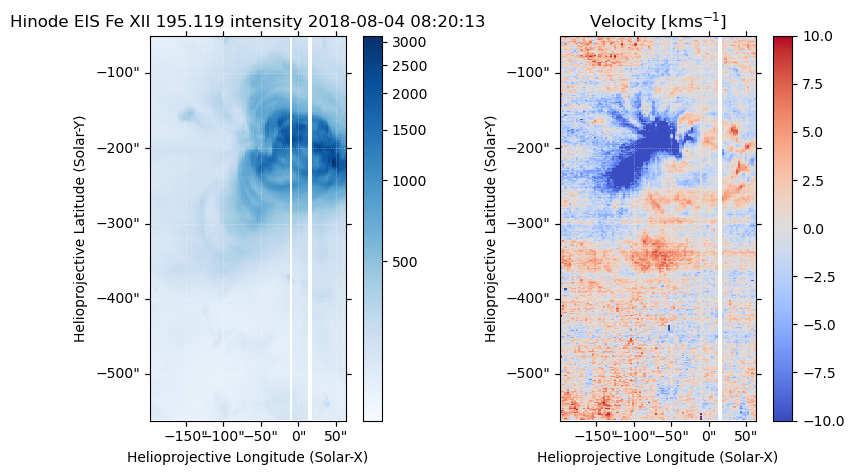

In [28]:
plt.style.use('default')
inten_map = fit_res.get_map(component=0, measurement='intensity')
vel_map = fit_res.get_map(component=0, measurement='velocity')
wd_map = fit_res.get_map(component=0, measurement='width')
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131,projection=inten_map)
im=inten_map.plot(axes=ax1, cmap = 'Blues')
fig.colorbar(im)
# plt.title('EIS Fe XII 195.12 13-06-2017')
# ax1.set_title('Fe XII 195.120 2013-10-14T01:12')

ax2 = fig.add_subplot(132,projection=vel_map)
im=vel_map.plot(axes=ax2,cmap='coolwarm')
fig.colorbar(im)
ax2.set_title(r'Velocity [kms$^{-1}$]')

### With the new Calibration applied to EIS data 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Text(0.5, 1.0, 'Velocity [kms$^{-1}$]')

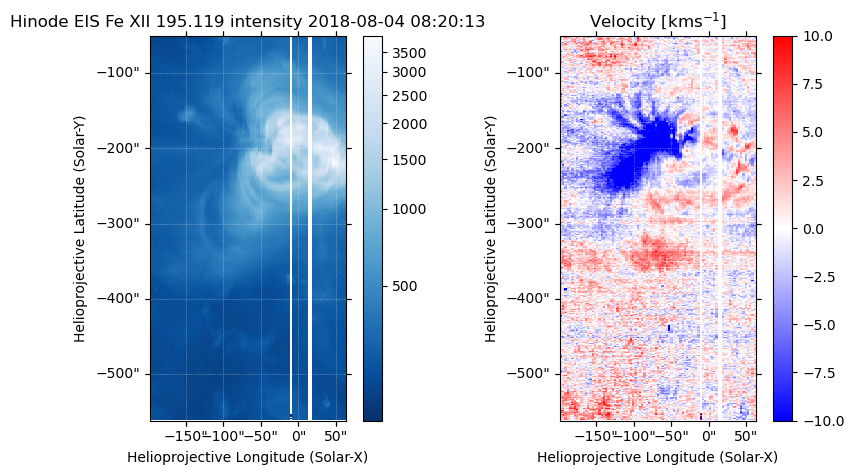

In [46]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131,projection=inten_map)
im=eis_calib_2023(inten_map).plot(axes=ax1, cmap = 'Blues_r')
fig.colorbar(im)
# plt.title('EIS Fe XII 195.12 13-06-2017')
# ax1.set_title('Fe XII 195.120 2013-10-14T01:12')

ax2 = fig.add_subplot(132,projection=vel_map)
im=vel_map.plot(axes=ax2,cmap='bwr')
fig.colorbar(im)
ax2.set_title(r'Velocity [kms$^{-1}$]')
# fig.suptitle('With EIS Calibration 2023 applied', y=0.98)

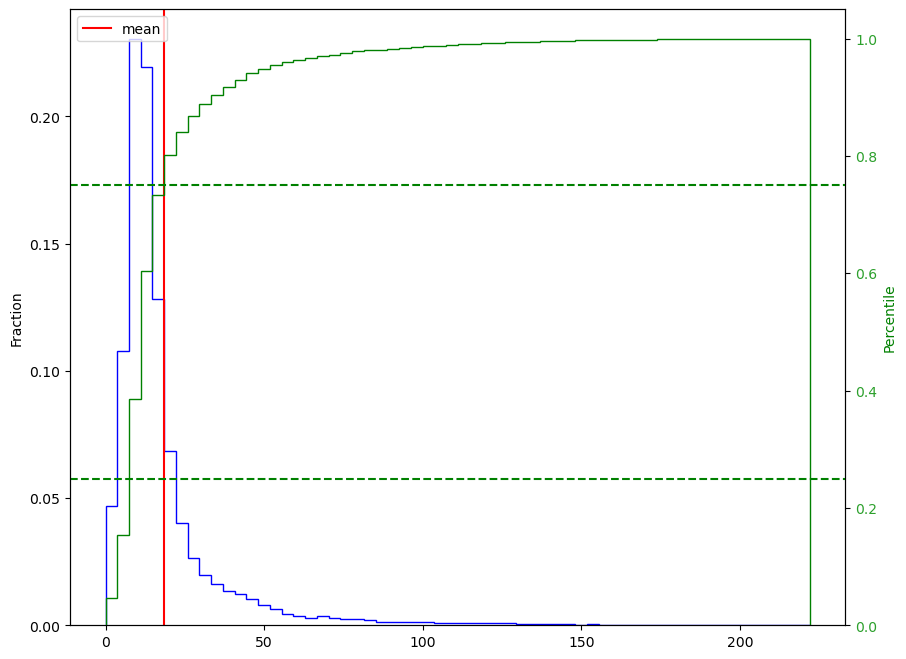

In [12]:
fig, ax1 = plt.subplots(figsize = (10,8))
bins1=60
ax1.hist(inten_map.data.ravel(),bins=bins1,histtype='step',cumulative=False,weights=np.ones(len(inten_map.data.ravel())) / len(inten_map.data.ravel()),lw=1.5,color='blue')
ax1.set_ylabel('Fraction')
# ax1.set_xlabel(r'Intensity [ergs cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
# ax1.set_title(r'EIS Fe XII 195.12: '+date_begin_EIS)
ax1.axvline(x=np.mean(inten_map.data.ravel()),color='red',label='mean')
ax1.legend(loc='upper left')
# ax1.set_xscale('log')

color = 'tab:green'
axs_twin=ax1.twinx()
axs_twin.hist(inten_map.data.ravel(),bins=bins1,histtype='step',cumulative=True,weights=np.ones(len(inten_map.data.ravel())) / len(inten_map.data.ravel()),lw=1.5,color='green')#hist(lifetime_red_combined[w2],bins=150,cumulative=True,histtype='step',density=True,color='green')
axs_twin.axhline(y=0.25, linestyle='dashed',color='green')
axs_twin.axhline(y=0.75, linestyle='dashed',color='green')
axs_twin.set_ylabel('Percentile',color='green')
axs_twin.tick_params(axis='y', labelcolor=color)

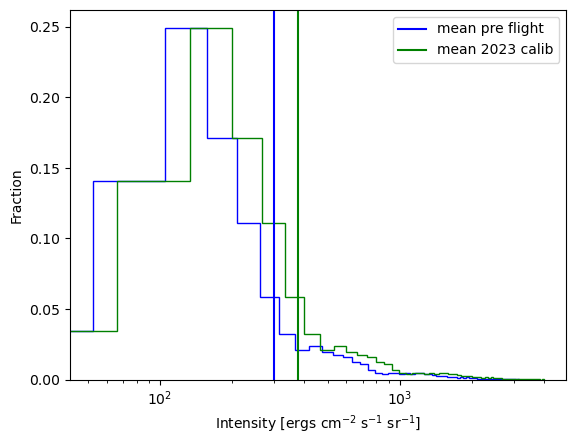

In [25]:
plt.hist(inten_map.data.ravel(),bins=bins1,histtype='step',cumulative=False,
         weights=np.ones(len(inten_map.data.ravel())) / len(inten_map.data.ravel()),lw=1.5,color='blue')
plt.hist(eis_calib_2023(inten_map).data.ravel(),bins=bins1,histtype='step',cumulative=False,
         weights=np.ones(len(eis_calib_2023(inten_map).data.ravel())) / len(eis_calib_2023(inten_map).data.ravel()),lw=1.5,color='green')
plt.axvline(x=np.mean(inten_map.data.ravel()),color='blue',label='mean pre flight')
plt.axvline(x=np.mean(eis_calib_2023(inten_map).data.ravel()),color='green',label='mean 2023 calib')
plt.legend(loc='best')
# plt.axhline(y=0.25, linestyle='dashed',color='green')
# plt.axhline(y=0.75, linestyle='dashed',color='green')
plt.ylabel('Fraction')
plt.xlabel(r'Intensity [ergs cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
plt.xscale('log')

## QS validation case as a sanity check

In [22]:
data1 = np.load('/Users/souvikb/MUSE_outputs/EIS_IRIS_QS_obs/combined_aia_observations.npz')
data1.files
all_171 = data1['a171_all']
all_193 = data1['a193_all']
all_131 = data1['a131_all']
all_211 = data1['a211_all']

Text(0.5, 0.95, 'All QS datasets')

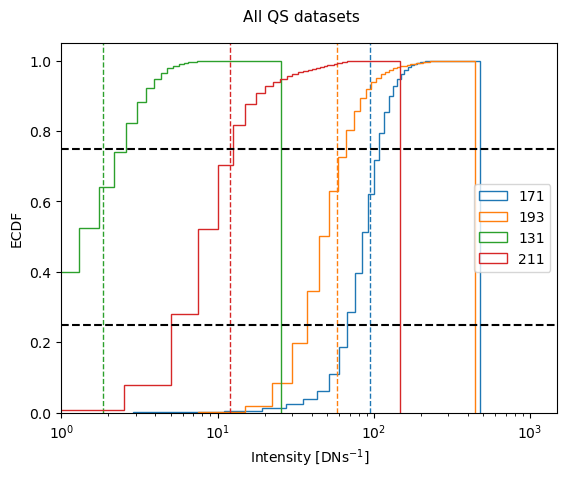

In [6]:
num_bins = 60
fig, ax = plt.subplots()
bins = np.linspace(all_171.min(), all_171.max(), num_bins)
hist, bin_edges = np.histogram(all_171, bins=bins)
ax.hist(all_171, bins=bins, label='171', histtype='step',cumulative=True, weights=np.ones(len(all_171)) / len(all_171))
ax.axvline(x=np.mean(all_171),color='#1f77b4',lw=1,ls='--')
# ax.yaxis.set_major_formatter(PercentFormatter(1))

bins = np.linspace(all_193.min(), all_193.max(), num_bins)
hist, bin_edges = np.histogram(all_193, bins=bins)
ax.hist(all_193, bins=bins, label='193', histtype='step', cumulative=True,weights=np.ones(len(all_193)) / len(all_193))
ax.axvline(x=np.mean(all_193),color='#ff7f0e',lw=1,ls='--')
# ax.yaxis.set_major_formatter(PercentFormatter(1))

bins = np.linspace(all_131.min(), all_131.max(), num_bins)
hist, bin_edges = np.histogram(all_131, bins=bins)
ax.hist(all_131.ravel(), bins=bins, label='131', histtype='step',cumulative=True,weights=np.ones(len(all_131)) / len(all_131))
ax.axvline(x=np.mean(all_131),color='#2ca02c',lw=1,ls='--')
# ax.yaxis.set_major_formatter(PercentFormatter(1))

bins = np.linspace(all_211.min(), all_211.max(), num_bins)
hist, bin_edges = np.histogram(all_211, bins=bins)
ax.hist(all_211, bins=bins, label='211', histtype='step',cumulative=True,weights=np.ones(len(all_211)) / len(all_211))
ax.axvline(x=np.mean(all_211),color='#d62728',lw=1,ls='--')
ax.set_xlabel(r'Intensity [DNs$^{-1}$]')
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('ECDF')
ax.set_xlim([1,1500])
# ax.set_ylim([0,0.2])
ax.legend()
ax.axhline(y=0.25,color='black',ls='--')
ax.axhline(y=0.75,color='black',ls='--')
fig.suptitle('All QS datasets',y=0.95,size=11)

In [8]:
unit = 'DN'
aia_resp = get_response(date ='2019-01-08T18:41:20' , channels=[131,171,193,211],save_response=False, units=unit)

*** Nearest response function is 7 months from obs_date 
*** /Users/souvikb/MUSE_outputs/response/aia_resp_DN_Jun18.zarr already exists! Reading...
The channels of the response function match.


In [10]:
muse_AIA_QS = aia_synthesis(aia_resp, work_dir, vdem_file, swap_dims = False)

*** Work directory is /Users/souvikb/MUSE_outputs/pipeline_figs_sims/
*** Loading /Users/souvikb/MUSE_outputs/vdems/muse_vdem_qs_en024031_los2_JMS_fixedvdop_2May2025_010.zarr into vdem


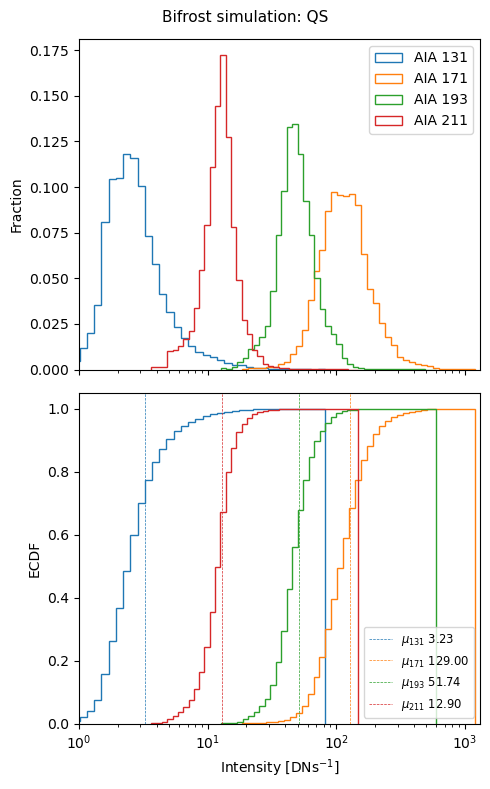

In [16]:
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(5,8),sharex=True)
ax.ravel()
colors_channel = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
channels = [131,171,193,211]
num_bins=40
for i, channel in enumerate([131,171,193,211]):
    synth_aiadata = muse_AIA_QS.flux.sel(channel=channel).to_numpy()
    # bins = np.linspace(muse_AIA.flux.sel(channel=channel).min(), muse_AIA.flux.sel(channel=channel).max(), num_bins)
    min_val = max(muse_AIA_QS.flux.sel(channel=channel).min(), 1e-1)  # avoid log(0)
    max_val = muse_AIA_QS.flux.sel(channel=channel).max()
    bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
    hist, bin_edges = np.histogram(synth_aiadata, bins=bins)
    
    ax[0].hist(synth_aiadata.ravel(), bins=bins, histtype='step',color=colors_channel[i], 
                label=f'AIA {channel}',weights=np.ones(len(synth_aiadata.ravel())) / len(synth_aiadata.ravel()))
    
    ax[0].legend(loc = 'best')
    ax[0].set_xscale('log')
    ax[0].set_ylabel('Fraction')

    ax[1].hist(synth_aiadata.ravel(), bins=bins, histtype='step', color=colors_channel[i],cumulative=True,
            weights=np.ones(len(synth_aiadata.ravel())) / len(synth_aiadata.ravel()))
    ax[1].set_xlabel(r'Intensity [DNs$^{-1}$]')
    ax[1].set_xscale('log')
    ax[1].set_ylabel('ECDF')
    ax[1].axvline(x=np.mean(synth_aiadata.ravel()),color=colors_channel[i],lw=0.5,ls='--',
                    label=f'$\mu_{{{channel}}}$ {np.mean(synth_aiadata.ravel()):.2f}')
    ax[1].set_xlim([1,muse_AIA_QS.flux.max().to_numpy()*1.1])
    ax[1].legend(loc='best', fontsize='small')
fig.suptitle(f'{MHD_code} simulation: {snapname}',y=0.98,size=11)
plt.tight_layout()

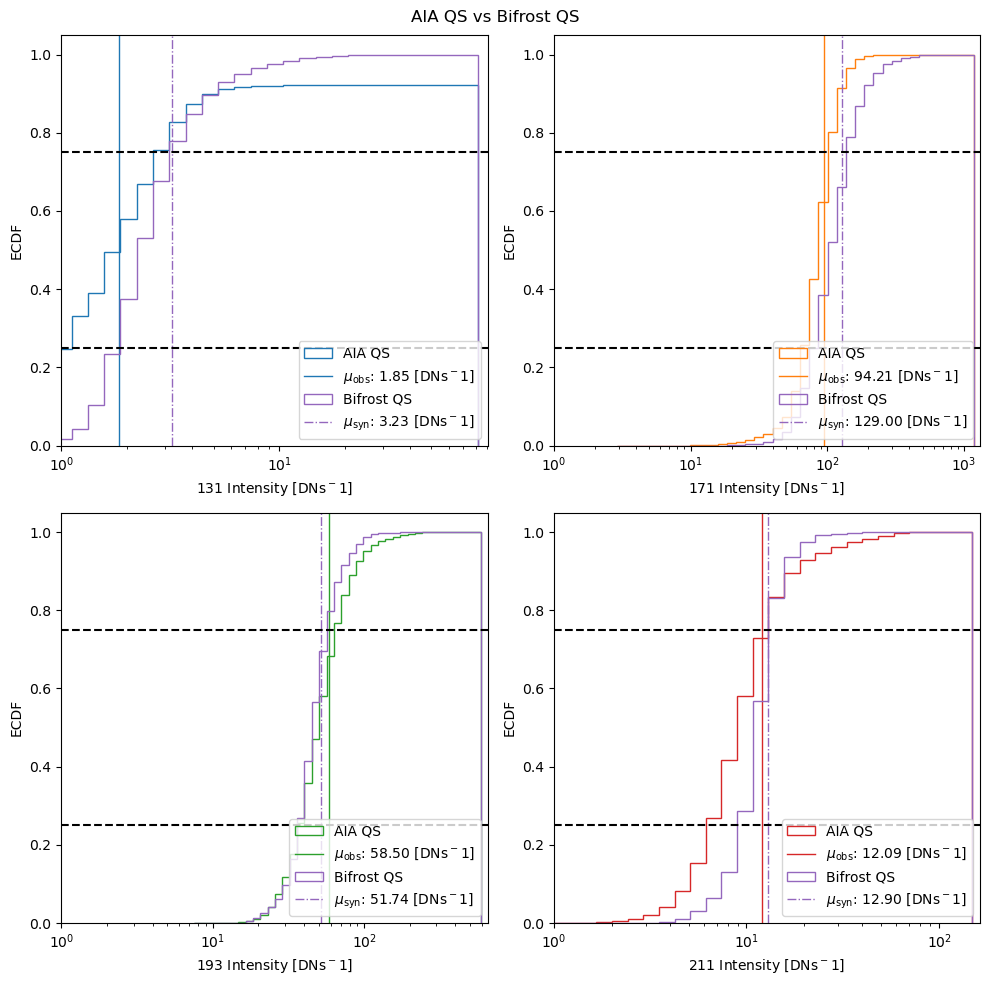

In [ ]:
region = 'QS'
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i,channel in enumerate(channels):
    # exp_time = AIA_DATA[channel].exposure_time
    data = np.ravel(data1['a'+str(channel)+'_all'])
    bf = muse_AIA_QS.flux.sel(channel=channel).to_numpy()
    combined = np.concatenate([data, bf.ravel()])
    min_val = max(combined.min(), 1e-1)  # avoiding log(0). This can be nasty otherwise
    max_val = combined.max()
    bins_new = np.logspace(np.log10(min_val), np.log10(max_val), num_bins)
    # bins_new = np.linspace(combined.min(), combined.max(), 60)
    hist, bin_edges = np.histogram(data, bins=bins_new)
    ax[i//2][i%2].hist(data, bins=bins_new, label=f'AIA {region}',cumulative=True, histtype='step',
                        weights=np.ones(len(data)) / len(data), color=colors_channel[i])
    ax[i//2][i%2].axvline(x=np.mean(data),color=colors_channel[i],lw=1,ls='-',
                            label=f'$\mu_{{\mathrm{{obs}}}}$: {np.mean(data):.2f} [DNs$^{-1}$]')

    ax[i//2][i%2].hist(bf.ravel(), bins=bins_new, label=f'{MHD_code} {snapname}',cumulative=True, histtype='step',
                        weights=np.ones(len(bf.ravel())) / len(bf.ravel()),color='tab:purple',ls='-.',lw=2.)
    ax[i//2][i%2].axvline(x=np.mean(bf.ravel()),color='tab:purple',lw=1,ls='-.',label=f'$\mu_{{\mathrm{{syn}}}}$: {np.mean(bf.ravel()):.2f} [DNs$^{-1}$]')
    ax[i//2][i%2].set_xlabel(fr'{channel} Intensity [DNs$^{-1}$]')
    ax[i//2][i%2].set_xlim([1, max_val * 1.1])
    # if channel == 171:
    #     ax[i//2][i%2].set_xlim([1, 1e4])
    # elif channel == 193:
    #     ax[i//2][i%2].set_xlim([1, 1e4])
    # elif channel == 211:
    #     ax[i//2][i%2].set_xlim([1, 3e3])
    # elif channel == 131:
    #     ax[i//2][i%2].set_xlim([1, 1e3])
    ax[i//2][i%2].set_xscale('log')
    ax[i//2][i%2].set_ylabel('ECDF')
    ax[i//2][i%2].legend(loc='lower right')
    ax[i//2][i%2].axhline(y=0.25,color='black',ls='--')
    ax[i//2][i%2].axhline(y=0.75,color='black',ls='--')

title = f"AIA {region} vs {MHD_code} {snapname}"
fig.suptitle(title,y=0.98)
plt.tight_layout()
plt.savefig()